In [46]:
#TODO task1: Tokenizer Training using BPE
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace    
from tokenizers.trainers import BpeTrainer

tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(vocab_size=6000, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.train(files=["data.txt"], trainer=trainer)

Count Ngrams: 38609it [08:39, 74.36it/s]  


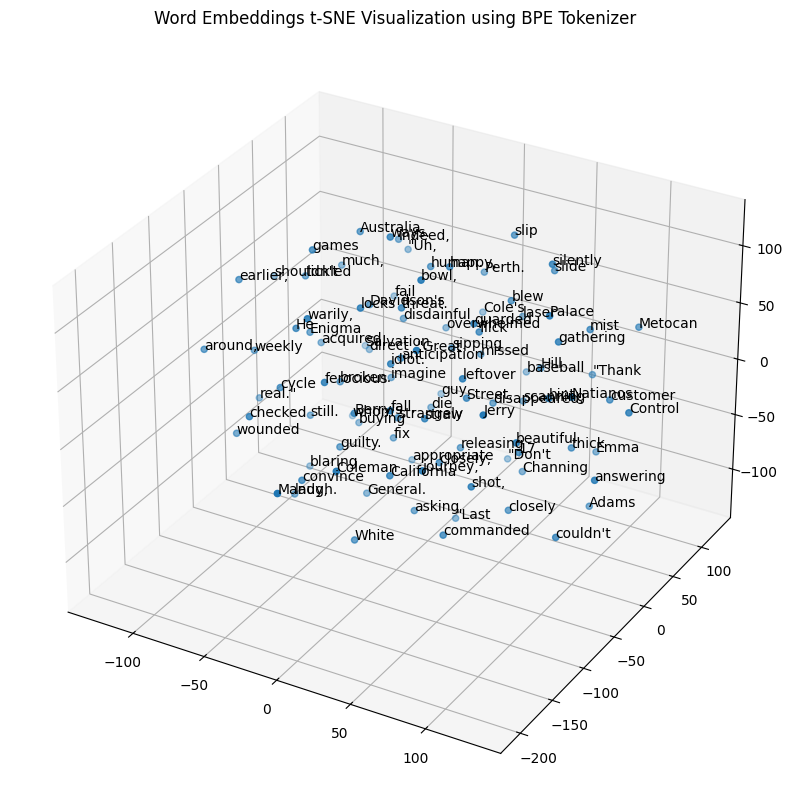

In [47]:
#TODO task2: Train a word embedding model using CBOW
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import numpy as np

random.seed(114)
np.random.seed(514)

with open('data.txt','r',encoding='utf-8') as file:
    data = file.readlines()
    
sentences = [line.strip().split() for line in data]
word2vec_model = Word2Vec(sentences, vector_size = 100, window=5, min_count=10, sg=0, workers=1, seed=0)

words = list(word2vec_model.wv.index_to_key)
random_words = random.sample(words,100)

word_vectors = np.array([word2vec_model.wv[word] for word in random_words])

# TODO visualization
tsne = TSNE(n_components=3, random_state=114)
word_vectors_tsne = tsne.fit_transform(word_vectors)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], word_vectors_tsne[:, 2])

for i, word in enumerate(random_words):
    ax.text(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1], word_vectors_tsne[i, 2], word)

plt.title("Word Embeddings t-SNE Visualization using BPE Tokenizer")
plt.show()


In [48]:
# TODO task3: train a word embedding model using BytePiece
from bytepiece import Trainer, Tokenizer

class corpus:
    def __iter__(self):
        f = 'data.txt'  
        with open(f, 'r', encoding='utf-8') as f:
            content = f.read()  
            for item in content.split('\n\n'):
                a=item.strip()
                if(a!=''):
                    yield a  

trainer = Trainer(order=6, max_vocab_size=6000, min_count=10)
trainer.train(corpus(), workers=1, batch_size=1000)
trainer.save('bytepiece.model')

Count Ngrams: 51288it [00:14, 3608.14it/s]
Prune Ngrams: 100% 7/7 [00:00<00:00, 24.25it/s]
Count Pieces: 51288it [00:52, 978.71it/s] 
Prune Pieces: 100% 374029/374029 [00:03<00:00, 105729.85it/s]
Prune Pieces: 100% 6598/6598 [00:00<00:00, 197740.76it/s]
Prune Pieces: 100% 6548/6548 [00:00<00:00, 199360.51it/s]
Prune Pieces: 100% 6547/6547 [00:00<00:00, 191545.18it/s]
Prune Pieces: 100% 550/550 [00:00<00:00, 33675.91it/s]
Prune Pieces: 100% 5997/5997 [00:00<00:00, 194061.19it/s]
Prune Pieces: 100% 5995/5995 [00:00<00:00, 196717.72it/s]


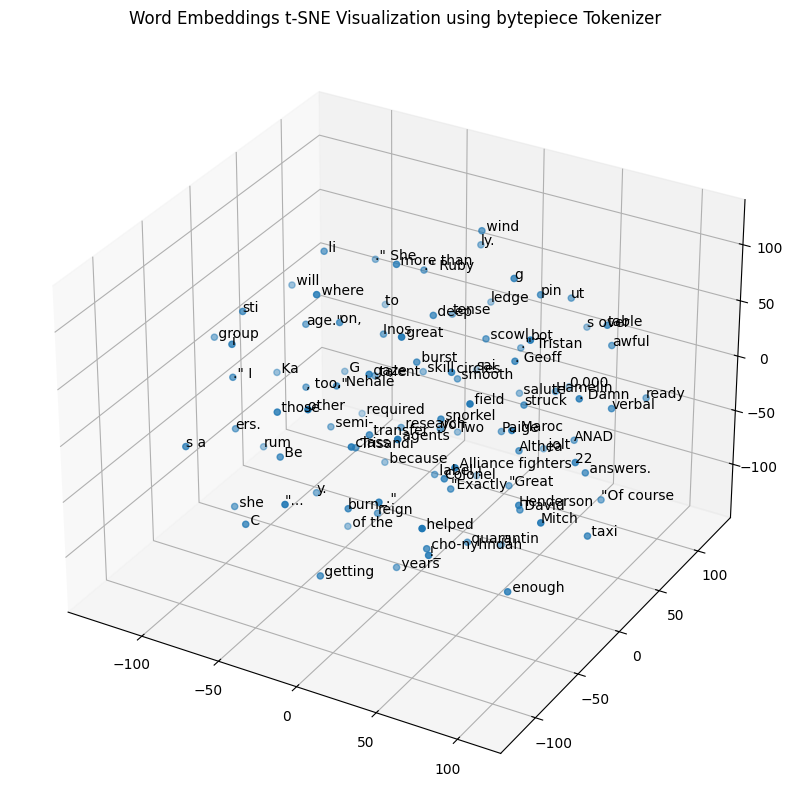

In [52]:
bytepiece_tokenizer = Tokenizer('bytepiece.model')

def load_corpus(path):
    with open(path,'r',encoding='utf-8') as f:
        content = f.read()
    return [item.strip() for item in content.split('\n\n') if item.strip()]

def tokenize_corpus(corpus):
    return [[token.decode('utf-8', errors='ignore') for token in bytepiece_tokenizer.tokenize(text)] for text in corpus]

corpus = load_corpus('data.txt')
tokenized_corpus = tokenize_corpus(corpus)

bytepiece_model = Word2Vec(tokenized_corpus, vector_size = 100, window=5, min_count=10, sg=0, workers=1, seed=0)

words_bytepiece = list(bytepiece_model.wv.index_to_key)
random_words_bytepiece = random.sample(words_bytepiece,100)

word_vectors_bytepiece = np.array([bytepiece_model.wv[word] for word in random_words_bytepiece])

# TODO visualization
tsne = TSNE(n_components=3, random_state=114)
word_vectors_tsne_bytepiece = tsne.fit_transform(word_vectors_bytepiece)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(word_vectors_tsne_bytepiece[:, 0], word_vectors_tsne_bytepiece[:, 1], word_vectors_tsne_bytepiece[:, 2])

for i, word in enumerate(random_words_bytepiece):
    ax.text(word_vectors_tsne_bytepiece[i, 0], word_vectors_tsne_bytepiece[i, 1], word_vectors_tsne_bytepiece[i, 2], word)

plt.title("Word Embeddings t-SNE Visualization using bytepiece Tokenizer")
plt.show()

In [60]:
#TODO task4: hand-written implementation
#1. BPE tokenizer
from collections import defaultdict, Counter

class BPETokenizer:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.bpe_codes = {}

    def get_stats(self, corpus):
        pairs = defaultdict(int)
        for word, freq in corpus.items():
            symbols = word.split()
            for i in range(len(symbols) - 1):
                pairs[symbols[i], symbols[i + 1]] += freq
        return pairs

    def merge_vocab(self, pair, v_in):
        v_out = {}
        bigram = ' '.join(pair)
        replacement = ''.join(pair)
        for word in v_in:
            w_out = word.replace(bigram, replacement)
            v_out[w_out] = v_in[word]
        return v_out

    def fit(self, corpus):
        corpus = {' '.join(word): freq for word, freq in corpus.items()}
        while len(self.bpe_codes) < self.vocab_size:
            pairs = self.get_stats(corpus)
            if not pairs:
                break
            best = max(pairs, key=pairs.get)
            corpus = self.merge_vocab(best, corpus)
            self.bpe_codes[best] = len(self.bpe_codes)

    def tokenize(self, word):
        word = ' '.join(word)
        for pair in self.bpe_codes:
            bigram = ''.join(pair)
            word = word.replace(' '.join(pair), bigram)
        return word.split()

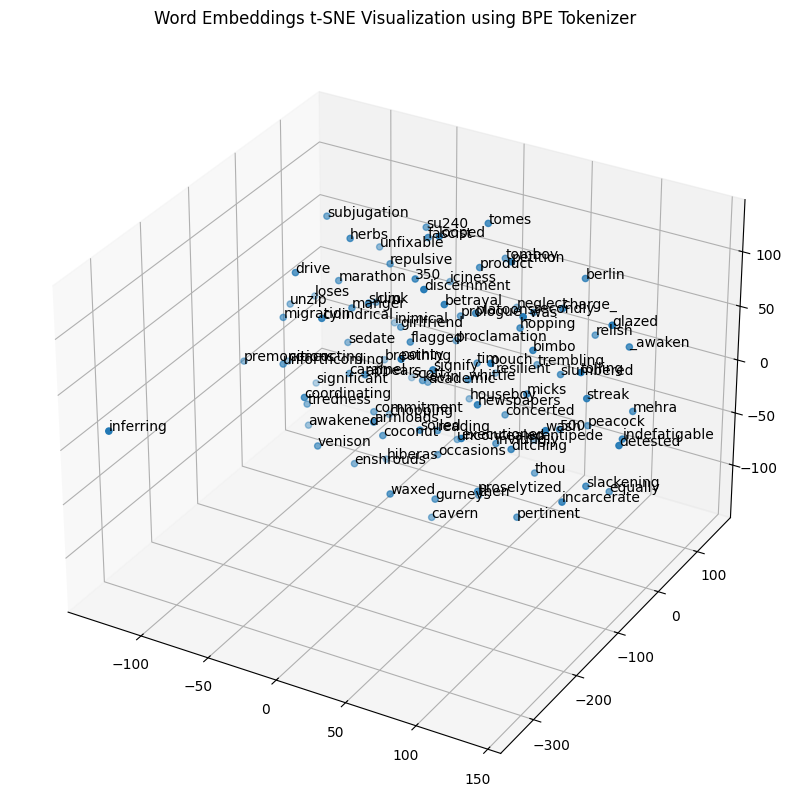

In [64]:
#2. word embedding
import re

class WordEmbedding:
    def __init__(self, vocab):
        self.vocab = vocab
        # 初始化每个词的词向量
        self.embeddings = {word: np.random.rand(100) for word in vocab}  # 100维的词向量

    def get_embedding(self, word):
        return self.embeddings.get(word, np.random.rand(100))
    
def load_corpus_handwritten(path):
    with open(path, 'r', encoding='utf-8') as f:
        content = f.read().lower()
    words = re.findall(r'\w+', content)
    corpus = Counter(words)
    return corpus   

def visualize_embeddings(embedding_model, vocab):
    words = random.sample(list(vocab), 100)
    embeddings = np.array([embedding_model.get_embedding(word) for word in words])

    tsne = TSNE(n_components=3, random_state=114)
    word_vectors_tsne = tsne.fit_transform(embeddings)

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], word_vectors_tsne[:, 2])

    #random_words = random.sample(words, min(len(words), 30))  # 随机选取30个词汇
    for i, word in enumerate(words):
        ax.text(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1], word_vectors_tsne[i, 2], word)

    plt.title("Word Embeddings t-SNE Visualization using BPE Tokenizer")
    plt.show()

corpus = load_corpus_handwritten('data.txt')
tokenizer = BPETokenizer(vocab_size=6000)
tokenizer.fit(corpus)
tokenized_corpus = {word: tokenizer.tokenize(word) for word in corpus}
embedding_model = WordEmbedding(set([subword for tokens in tokenized_corpus.values() for subword in tokens]))
visualize_embeddings(embedding_model, corpus)